$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 2: Linear Regression with Fixed Nonlinear Features

*Alexander Day*

## Overview

The objective of this assignment is to use nonlinear transformation on a set of features to predict a target value. Given samples of feature data and known target values, linear regression is used on nonlinear transformations of the feature data to model the relationship between the features and predict target values. A best fit linear model is obtained on the transformed feature data by adjusting the weight parameter,$\wv$ to minimize the sum of the squared errors.

## Method

The functions that were developed in the first assignment build models that are linear
in the parameter $\wv$. This allows us to determine the minimum of the function
by finding the value of $\wv$ that minimizes the least squares function, 

$$
\wv_{\mbox{best}} = \argmin{\wv} \sum_{n=1}^N (t_n - g(x_n ; \wv))^2
$$

In the first assignment the $\wv$ was explained to be found by taking the first 
derivative of this function and setting it equal to zero yielding

$$
\wv = (\Xv^T \Xv)^{-1} \Xv^T \Tv
$$


These functions are limited however when the
features do not yield a linear model that appropriately fits the 
target data. To overcome this limitation it is possible to perform a 
nonlinear transformation of the input features and use this to produce
a more accurate model of the target data.

To understand this process, have a look at one input attribute vector.

$$
\begin{alignat*}{1}
 \xv &= \begin{bmatrix}
       x_0\\
       x_1\\
       \vdots \\
       x_N
       \end{bmatrix}
\end{alignat*}
$$

Now consider adding powers of $\xv$ and building this vector into a matrix. 
For example if we consider up to power $n$ the resulting matrix. $X$ would be

$$
\begin{alignat*}{1}
 X &= \begin{bmatrix}
       x_0 & x_0^2 & ... &x_0^n\\
       x_1 & x_1^2 & ... &x_1^n\\
       \vdots \\
       x_N & x_N^2 & ... & x_N^n\\
       \end{bmatrix}
\end{alignat*}
$$

Performing least-squares linear regression on this new feature matrix will allow for the 
prediction of target values when given new input features.

To support implementation of linear regression on nonlinear features 
in a single function it is necessary to define supporting functions.
The first such functions we define are those that form the core of the linear
regression, the `train`, `use` and `rmse` functions.

In [1]:
#library imports to support defined functions
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def train(X,T):
    Xs = (X - X.mean(axis=0)) / X.std(axis=0)
    Xtrain = np.hstack((np.ones((Xs.shape[0],1)), Xs))
    w = np.linalg.lstsq(np.dot(Xtrain.T,Xtrain), np.dot(Xtrain.T, T))
    w = w[0]
    return {'means':X.mean(0), 'stds':X.std(0), 'w': w}

def use(X,model):
    columnOfOnes = np.ones(( X.shape[0],1 ))
    Xs1 = np.hstack((columnOfOnes, (X-model['means'])/model['stds']))
    return np.dot( Xs1, model['w'] )

def rmse(predict,T):
    return np.sqrt(np.mean((predict-T)**2 ))

The next functions defined aid in performing computations across a 
range of nonlinear transformations to test determine which transform
produces the best possible model. 

The function `makeFeatures(X,maxPower)` returns a matrix that is a concatenation of the 
input data and it's transformation up to the power maxPower, $X, X^2, ..., X^{maxPower}$.

The function `partitionKFolds(X,T,nFolds,shuffle=False,nPartitions=2)` loops through 
`nFolds` different folds of the data split into training and testing subsets.

The function `meansAfterGroupedByFirstColumn(data)` transforms `data` to a numpy array
where the entries in the first column serves as an identifier and all other column entries 
are averaged with all entries in their column that have the same entry in the identifier column.
This function is useful in collapsing all `nFolds` of each power to produce an average `rmse` 
for that power.

In [3]:
def makeFeatures(X,maxPower):
    Xf = X
    for power in range(2,maxPower+1):
        Xf = np.hstack((Xf,X**(power)))
    return Xf

def partitionKFolds(X,T,nFolds,shuffle=False,nPartitions=2):
    '''Usage: for Xtrain,Ttrain,Xval,Tval,Xtest,Ttext in partitionKFolds(X,T,5):'''
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    for testFold in range(nFolds):
        if nPartitions == 3:
            # Repeat with validateFold taking each single fold, except for the testFold
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # trainFolds are all remaining folds, after selecting test and validate folds
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                # Construct Xtrain and Ttrain by collecting rows for all trainFolds
                rows = []
                for tf in trainFolds:
                    a,b = startsStops[tf]                
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]
                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]
                # Construct Xtest and Ttest
                a,b = startsStops[testFold]
                rows = rowIndices[a:b]
                Xtest = X[rows,:]
                Ttest = T[rows,:]
                # Return partition matrices, then suspend until called again.
                yield Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest,testFold
        else:
            # trainFolds are all remaining folds, after selecting test and validate folds
            trainFolds = np.setdiff1d(range(nFolds), [testFold])
            # Construct Xtrain and Ttrain by collecting rows for all trainFolds
            rows = []
            for tf in trainFolds:
                a,b = startsStops[tf]                
                rows += rowIndices[a:b].tolist()
            Xtrain = X[rows,:]
            Ttrain = T[rows,:]
            # Construct Xtest and Ttest
            a,b = startsStops[testFold]
            rows = rowIndices[a:b]
            Xtest = X[rows,:]
            Ttest = T[rows,:]
            # Return partition matrices, then suspend until called again.
            yield Xtrain,Ttrain,Xtest,Ttest,testFold
            
def meansAfterGroupedByFirstColumn(data):
    result = []
    uniqs = np.unique(data[:,0])
    for x in uniqs:
        forx = data[data[:,0] == x, 1:]
        result.append([x] + np.mean(forx,0).tolist())
    return np.array(result)

With these supporting functions defined, it is no possible to perform
the linear regression with nonlinear features using the following function 
that takes as arguments, `X`: the input feature data grouped with one column
for each feature, `T`: the target values as a column vector, `nFolds`: the
number of ways to partition `X` and build models for each power, `maxPowers`: the
set of powers to test. 

In [4]:
def findBestPower(X,T,nFolds,maxPowers):
    avgs = []
    for power in maxPowers:
        Xf = makeFeatures(X,power)
        for Xtrain,Ttrain,Xtest,Ttest,_ in partitionKFolds(Xf,T,nFolds):
            model = train(Xtrain,Ttrain)
            Ytest = use(Xtest,model)
            RMSEtest = rmse(Ytest.flatten(),Ttest.flatten())
            Ytrain = use(Xtrain,model)
            RMSEtrain = rmse(Ytrain.flatten(),Ttrain.flatten())          
            avgs.append([power,RMSEtrain,RMSEtest])
    avgs = meansAfterGroupedByFirstColumn(np.array(avgs))
    testErrors = avgs[:,2]
    maxP = testErrors.argmin()+1 #add one for change from index to correlating power
    return maxP,avgs

## Data

In this assignment audio features are used to predict the geographical origin of a song.The dataset was built from a personal collection of 1059 tracks covering 33 countries/area. The music used is traditional, ethnic or world only, as classified by the publishers of the product on which it appears. Any Western music is not included because its influence is global and being able to specify a location with strong influence on the music is central. 

The first 68 columns are extracted audio features and the last two are the targets, the latitude and longitude of the location of production. The program MARSYAS[1] was used to extract audio features from the wave files. We used the default MARSYAS settings in single vector format (68 features) to estimate the performance with basic timbal information covering the entire length of each track. No feature weighting or pre-filtering was applied. All features were transformed to have a mean of 0, and a standard deviation of 1.

The dataset mainpage is found on the UCI machine learning repository at http://archive.ics.uci.edu/ml/datasets/Geographical+Original+of+Music# and the creators are Fang Zhou, Claire Q and Ross. D. King at The University of Nottinghan, Ningbo, China.

A link to zip file containing data: http://archive.ics.uci.edu/ml/machine-learning-databases/00315/

Note: There are two data sets, the one used in this notebook is `'default_features_1059_tracks.txt'.`

[1] G. Tzanetakis and P. Cook, MARSYAS: a framework for audio analysis, Organised Sound, vol. 4, pp. 169-175, 2000.

In [5]:
#let's read in the dataset
def readAudioData(filename='audio-features.data'):
    data = np.loadtxt(filename,usecols=range(70),delimiter = ',')
    print("Read",data.shape[0],"rows and",data.shape[1],"columns from",filename)
    X = data[:,:67]
    T = data[:,68:]
    return X,T

In [6]:
X,T = readAudioData()

Read 1059 rows and 70 columns from audio-features.data


## Results

Now let's plot the 68 feature values (each a different color) among the 1059 audio track instances. This will give us an initial idea as to whether or not there exists a correlation among the features that will be useful in performing the linear regression.

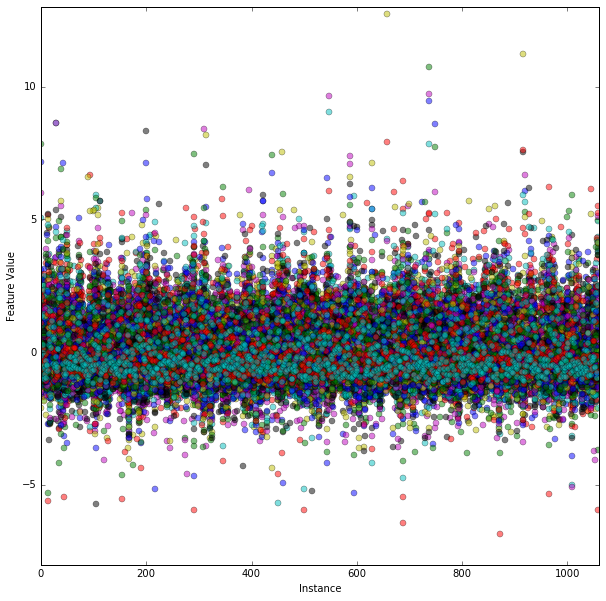

In [21]:
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(np.abs(X[:,i]),np.abs(T),'.')

While this plot is highly noisy, it is clear that the peaks of features often align, giving an indication that a linear model is possibly a nice fit for the data.

Now employ the function `findBestPower(X,T,nFolds,maxPowers)` to find the best tranform of the audio features that yields the model to best predict the latitude and longitude of the origin of the audio track. Since we are predicting two features we perform the linear regression twice, once to predict the latitude and then to predict the longitude.

Let's use 10 folds of the data and test max powers of [1,2,3,4,5].

In [19]:
latMaxPow, latAvgs = findBestPower(X,T[:,0:1],10,[1,2,3,4,5])
longMaxPow, longAvgs =  findBestPower(X,T[:,1:2],10,[1,2,3,4,5])
print("The power that yields the lowest test RMSE in predicting latitude is",latMaxPow)
print("\nThe power that yields the lowest test RMSE in predicting longitutde is",longMaxPow)

The power that yields the lowest test RMSE in predicting latitude is 1

The power that yields the lowest test RMSE in predicting longitutde is 1


From these results it appears that performing the data transform does not result in
any better of a model than simply performing linear regression on the data directly.
Let's take a look at the root mean square averages among the powers.

In [20]:
%precision 3
print("The root mean square averages among powers 1-5 for latitude are:")
print('POWER  TRAIN_ERR  TEST_ERR')
for row in latAvgs:
    print('   {:.0f}   {:.4f}    {:.4f}'.format(*row))
print("The root mean square averages among powers 1-5 for latitude are:")
print('POWER  TRAIN_ERR  TEST_ERR')
for row in longAvgs:
    print('   {:.0f}   {:.4f}    {:.4f}'.format(*row))

The root mean square averages among powers 1-5 for latitude are:
POWER  TRAIN_ERR  TEST_ERR
   1   15.5134    16.9987
   2   14.3832    17.8403
   3   13.5354    21.3946
   4   12.8213    31.8942
   5   12.1163    89.2239
The root mean square averages among powers 1-5 for latitude are:
POWER  TRAIN_ERR  TEST_ERR
   1   40.8954    44.4441
   2   38.1896    46.9646
   3   35.9042    54.4623
   4   34.0639    89.3603
   5   31.2482    333.8050


So it is that the lowest test RMSE is using the original data without a transform, or power 1. 
Since this is the case let's use a model with no transformation and see how well 
it predicts location. As we are only using power 1 we can resort to our originally defined linear regression 
functions with no need to perform the nonlinear transformations of the audio features.
Let's take a look at 5 folds of models for both latitude and longitude predictions. The different color
dots each represent a different fold.

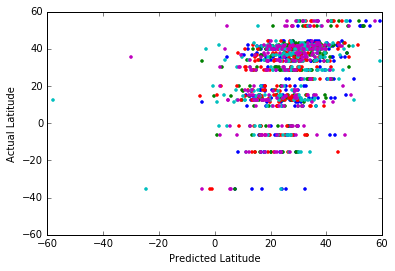

In [25]:
for Xtrain,Ttrain,Xtest,Ttest,_ in partitionKFolds(X,T[:,0:1],5):
    model = train(Xtrain,Ttrain)
    predict = use(Xtest,model)
    plt.plot(predict,Ttest,'.')
plt.xlabel('Predicted Latitude');
plt.ylabel('Actual Latitude');
plt.xlim(-60,60);
plt.ylim(-60,60);

This model fits the data well where the majority of the data is, particularly around values of 20-40.

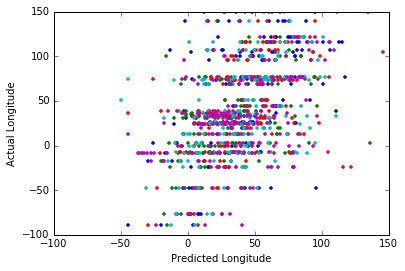

In [26]:
for Xtrain,Ttrain,Xtest,Ttest,_ in partitionKFolds(X,T[:,1:],5):
    model = train(Xtrain,Ttrain)
    predict = use(Xtest,model)
    plt.plot(predict,Ttest,'.')
plt.xlabel('Predicted Longitude');
plt.ylabel('Actual Longitude');
plt.xlim(-100,150);
plt.ylim(-100,150);

The plot of actual vs. predicted longitude is similar to that of the latitudes in that the predicted values match the actual around the clusters of the majority of the data, in the range of 0-100.

A notable feature of this data that is now apparent is that the actual latitude and longitude fall along well-defined horizontal lines. This is likely due to the fact the the geographical origin of the music is often clustered to a few areas, likely cities with high populations. Therefore a better analysis of the data may be to build categories for each city, grouped by both latitude and longitude, and then combine the latitude and longitude predictions to categorize the location among the finite set of origin locations.Therefore a combined approach utilizing classification may give the best model to determine the geographical origin of a given track.

## Grading

In [27]:
#define data making function used by 'A2grader.py'
def makeMPGData(filename='auto-mpg.data'):
    def missingIsNan(s):
        return np.nan if s == b'?' else float(s)
    data = np.loadtxt(filename, usecols=range(8), converters={3: missingIsNan})
    print("Read",data.shape[0],"rows and",data.shape[1],"columns from",filename)
    goodRowsMask = np.isnan(data).sum(axis=1) == 0
    data = data[goodRowsMask,:]
    print("After removing rows containing question marks, data has",data.shape[0],"rows and",data.shape[1],"columns.")
    X = data[:,1:]
    T = data[:,0:1]
    Xnames =  ['cylinders','displacement','horsepower','weight','acceleration','year','origin']
    Tname = 'mpg'
    return X,T,Xnames,Tname

In [28]:
%run -i 'A2grader.py'

Read 398 rows and 8 columns from auto-mpg.data
After removing rows containing question marks, data has 392 rows and 8 columns.
20/20 points. 'findBestPower(X,T,nFolds=20,maxPowers=[1])' correctly returns 1
20/20 points. 'findBestPower(X,T,nFolds=20,maxPowers=range(1, 4))' correctly returns 3
20/20 points. 'findBestPower(X,T,nFolds=20,maxPowers=range(1, 10))' correctly returns 3
20/20 points. 'In power,avgs = findBestPower(X,T,nFolds=10,maxPowers=range(1,10))', your 'avgs' array is correct.

a2 Grade is 80/100
Up to 20 more points will be given based on the qualty of your descriptions of the method and the results.
